In [1]:
import numpy as np
import pickle
from lammps_implicit_der.systems import Bcc, BccBinary, BccBinaryVacancy, BccVacancy, BccSIA
from lammps_implicit_der.tools import plot_tools
import matplotlib.pyplot as plt


# Systems

In [2]:
bcc_pure = Bcc(alat=3.18427, ncell_x=2, minimize=True, logname=None, data_path='./refs/', snapcoeff_filename = 'W.snapcoeff', verbose=False)
print(bcc_pure.energy)
print(bcc_pure.Ndesc)
print(bcc_pure.dU_dTheta @ bcc_pure.Theta)

-89.060889667491
55
-89.06088966749098


In [3]:
bcc_pure = Bcc(alat=3.18, ncell_x=2, minimize=False, logname=None, data_path='./refs/', snapcoeff_filename = 'W.snapcoeff', verbose=False)
print(bcc_pure.energy)

-89.0555278168474


In [4]:
bcc_vac = BccVacancy(alat=3.163, ncell_x=2, minimize=True, logname=None, data_path='./refs/', snapcoeff_filename = 'W.snapcoeff', verbose=False)
print(bcc_vac.energy)
print(bcc_vac.Natom)

-80.36527467896518
15


In [5]:
bcc_binary = BccBinary(alat=3.13, ncell_x=2, minimize=True, logname=None, data_path='./refs/', snapcoeff_filename = 'NiMo.snapcoeff', verbose=False)
print(bcc_binary.energy)
print(bcc_binary.Natom)
print(bcc_binary.species)
print(bcc_binary.Ndesc)

-122.76839711519715
16
[1 1 1 2 2 2 2 2 2 1 1 2 1 1 1 1]
30


In [6]:
bcc_binary = BccBinaryVacancy(alat=3.13, ncell_x=2, minimize=True, logname=None, data_path='./refs/', snapcoeff_filename = 'NiMo.snapcoeff', verbose=False)
print(bcc_binary.energy)
print(bcc_binary.Natom)
print(bcc_binary.species)

-116.12471812826522
15
[1 1 1 2 2 2 2 2 2 1 1 2 1 1 1]


In [7]:
bcc_SIA = BccSIA(alat=3.18, ncell_x=2, minimize=False, logname=None, data_path='./refs/', snapcoeff_filename = 'W.snapcoeff', verbose=False)
print(bcc_SIA.energy)
print(bcc_SIA.Natom)

-53.04187280340517
17


In [8]:
alat0 = 3.175
ncell_x = 2
system = BccVacancy(alat=alat0, ncell_x=ncell_x, minimize=True, logname=None,
                    data_path='./refs/', snapcoeff_filename='W.snapcoeff', fix_box_relax=True, verbose=False)

alat = system.volume**(1/3) / ncell_x
print(alat)
print(system.energy)

3.163163264038606
-80.3652809680334


# Potential object

In [9]:
bcc_binary = BccBinary(alat=3.13, specie_B_concentration=0.2, ncell_x=2, minimize=False, logname=None, data_path='./refs/', snapcoeff_filename = 'NiMo.snapcoeff', verbose=False)
print(bcc_binary.pot.Theta_dict.keys())
print(bcc_binary.pot.Theta_dict['weights'], bcc_binary.pot.Theta_dict['radii'])
print(bcc_binary.pot.Theta_dict['Mo']['beta0'])
assert all( el in bcc_binary.pot.Theta_dict for el in ['Ni', 'Mo'])

dict_keys(['Ni', 'Mo', 'radii', 'weights'])
0.5 1.0 0.575 0.575
-11.1413071988


In [10]:
bcc_pure = Bcc(alat=3.18427, ncell_x=2, minimize=False, logname=None, data_path='./refs/', snapcoeff_filename='W.snapcoeff', verbose=False)
coeffs = np.loadtxt('./refs/W.snapcoeff', skiprows=7)
print(coeffs.shape)
print(bcc_pure.pot.Theta_dict['W']['Theta'].shape)

(55,)
(55,)


# System properties

In [11]:
bcc_vacancy = BccVacancy(alat=3.163, ncell_x=1, minimize=False, logname=None, data_path='./refs/', snapcoeff_filename='W.snapcoeff', verbose=False)
print(bcc_vacancy.energy)
print(bcc_vacancy.dU_dTheta @ bcc_vacancy.Theta)
print(bcc_vacancy.X_coord)

print(bcc_vacancy.cell)
print(bcc_vacancy.inv_cell)

-11.115719916006501
-11.1157199160065
[ 0.03163  0.03163  0.03163 -1.54987 -1.54987 -1.54987]
[[3.163 0.    0.   ]
 [0.    3.163 0.   ]
 [0.    0.    3.163]]
[[0.31615555 0.         0.        ]
 [0.         0.31615555 0.        ]
 [0.         0.         0.31615555]]


In [12]:
X_coord_test = bcc_vacancy.X_coord.copy()
X_coord_test[0] = 20.0
X_coord_test[3] = 50.0
bcc_vacancy.X_coord = X_coord_test
print(bcc_vacancy.X_coord)

[ 1.022    0.03163  0.03163 -0.608   -1.54987 -1.54987]


In [13]:
cell0 = bcc_vacancy.cell.copy()
strain = 1.5
cell_test = np.dot(cell0, np.eye(3) * strain)
bcc_vacancy.apply_strain(cell_test, update_system=True)
print(bcc_vacancy.cell)
bcc_vacancy.apply_strain(cell0, update_system=True)

[[4.7445 0.     0.    ]
 [0.     4.7445 0.    ]
 [0.     0.     4.7445]]


In [14]:
print(bcc_vacancy.volume)

31.644451746999998


In [15]:
bcc_vacancy = BccVacancy(alat=3.163, ncell_x=1, minimize=False, logname=None, data_path='./refs/', snapcoeff_filename='W.snapcoeff', verbose=False)
print(bcc_vacancy.dU_dTheta)
X_coord_test = bcc_vacancy.X_coord.copy()
X_coord_test[4] = 0.5
bcc_vacancy.scatter_coord(X_coord=X_coord_test)
bcc_vacancy.compute_D_dD()
bcc_vacancy.gather_D_dD()
print(bcc_vacancy.dU_dTheta.shape)
print(bcc_vacancy.mixed_hessian.shape)

# save mixed hessian to npy
np.save('test_system_props_dU_dTheta.npy', bcc_vacancy.dU_dTheta)
np.save('test_system_props_mixed_hessian.npy', bcc_vacancy.mixed_hessian)

# load mixed hessian from npy
mixed_hessian = np.load('test_system_props_mixed_hessian.npy')


[550.51114458   2.01479374  -5.99821035  -5.99993478  -8.00846585
  -5.99999999  -9.9999742  143.41878999 -22.66293236  -7.96996449
 -11.99406225  34.92610888  29.79360043 168.39461996 -14.73697034
  -9.97213532 -13.97448532  -7.87213139  41.26969941  30.12738214
  45.58408436  35.2644781    2.8297426  -13.76368866 -11.99952588
 -15.99261993  -4.92320288  -6.85702118 -12.4324085  -13.35457254
  -8.40087413 -17.70520886 519.47576739 -16.41943691 -14.02526168
 -17.996125    65.06167156  48.15601955  20.18407558 -22.04668129
  40.91004687  90.75393928 323.64108603 -33.01066077 -15.97312894
  12.96415603  26.55092319  -9.57943424  51.48242956  16.47068853
 300.97239624 -17.99041169  16.26521112  22.15065682   1.62815362]
(55,)
(55, 6)


In [16]:
bcc_binary = BccBinary(alat=3.13, ncell_x=2, minimize=True, logname=None,
                        data_path='./refs/', snapcoeff_filename='NiMo.snapcoeff', verbose=False)

print(bcc_binary.dU_dTheta.shape)
print(bcc_binary.mixed_hessian.shape)
print(bcc_binary.species)
# save mixed hessian to npy
np.save('test_system_props_dU_dTheta_binary.npy', bcc_binary.dU_dTheta)
np.save('test_system_props_mixed_hessian_binary.npy', bcc_binary.mixed_hessian)

(30,)
(30, 48)
[1 1 1 2 2 2 2 2 2 1 1 2 1 1 1 1]


### Forces

In [17]:
bcc_vacancy = BccVacancy(alat=3.163, ncell_x=1, minimize=False, logname=None, data_path='./refs/', snapcoeff_filename='W.snapcoeff', verbose=False)
dX_vector = np.zeros(bcc_vacancy.Natom*3)
dX_vector[0] = 0.1
print(', '.join(map(str,bcc_vacancy.forces(dx=dX_vector))))

-0.05229752523716957, 9.575673587391975e-16, 2.847605337023395e-15, 0.05229752523716957, -1.0269562977782698e-15, -2.9211995299477888e-15


### Hessian

In [18]:
bcc_vacancy = BccVacancy(alat=3.163, ncell_x=1, minimize=False, logname=None, data_path='./refs/', snapcoeff_filename='W.snapcoeff', verbose=False)
print(bcc_vacancy.hessian())
np.save('test_system_props_hessian.npy', bcc_vacancy.hessian())

h_test = np.load('test_system_props_hessian.npy')
print(np.allclose(bcc_vacancy.hessian(), h_test))

[[ 1.04601487e+01  2.08166817e-13 -1.54039509e-14 -1.04581487e+01
  -1.21430643e-13  7.45542618e-14]
 [-3.05311332e-13  1.04601487e+01  2.46549801e-13  2.22044605e-13
  -1.04581487e+01 -8.52795848e-14]
 [-2.49800181e-13  1.70002901e-13  1.04601487e+01  2.77555756e-13
  -3.46944695e-13 -1.04581487e+01]
 [-1.04581487e+01  7.52869989e-13 -3.38438880e-13  1.04601487e+01
  -6.52256027e-13  3.35773745e-13]
 [ 9.43689571e-13 -1.04581487e+01 -1.23754533e-13 -7.77156117e-13
   1.04601487e+01  7.67038494e-14]
 [ 3.60822483e-13  7.63278329e-14 -1.04581487e+01 -3.33066907e-13
  -1.45716772e-13  1.04601487e+01]]
True


In [19]:
bcc_vacancy = Bcc(alat=3.163, ncell_x=1, minimize=False, logname=None, data_path='./refs/', snapcoeff_filename='W.snapcoeff', verbose=False)
X_coord_test = bcc_vacancy.X_coord.copy()
#X_coord_test[4] = 0.5
bcc_vacancy.scatter_coord(X_coord=X_coord_test)
bcc_vacancy.compute_D_dD()
bcc_vacancy.gather_D_dD()
print(bcc_vacancy.dU_dTheta.shape)
print(bcc_vacancy.mixed_hessian.shape)

# save mixed hessian to npy
np.save('test_system_props_dU_dTheta.npy', bcc_vacancy.dU_dTheta)
np.save('test_system_props_mixed_hessian.npy', bcc_vacancy.mixed_hessian)

(55,)
(55, 6)


In [20]:
bcc_vacancy = Bcc(alat=3.163, ncell_x=1, minimize=False, logname=None, data_path='./refs/', snapcoeff_filename='W.snapcoeff', verbose=False)
print(bcc_vacancy.dU_dTheta.shape)
print(bcc_vacancy.mixed_hessian.shape)

# save mixed hessian to npy
np.save('test_system_props_dU_dTheta.npy', bcc_vacancy.dU_dTheta)
np.save('test_system_props_mixed_hessian.npy', bcc_vacancy.mixed_hessian)

(55,)
(55, 6)


In [21]:
bcc_system_tmp = Bcc(alat=3.163, ncell_x=1, minimize=False, logname=None, data_path='./refs/', snapcoeff_filename='W.snapcoeff', verbose=False)
X_coord_test = bcc_vacancy.X_coord.copy()
X_coord_test[4] = 0.5
bcc_system_tmp.scatter_coord(X_coord=X_coord_test)
bcc_system_tmp.X_coord


array([ 0.03163,  0.03163,  0.03163, -1.54987,  0.5    , -1.54987])

### write_data()

In [22]:
bcc_system_tmp = Bcc(alat=4.0, ncell_x=1, minimize=False, logname=None,
                         data_path='./refs/', snapcoeff_filename='W.snapcoeff', verbose=False)

bcc_system_tmp.write_data('bcc.data')
print(bcc_system_tmp.energy)

-4.628609827075535


In [23]:
bcc_from_data = Bcc(datafile='bcc.data', minimize=False, data_path='./refs', snapcoeff_filename='W.snapcoeff', logname=None, verbose=False)
print(bcc_from_data.energy)

-4.628609827075535


### pressure

In [24]:
bcc_system = Bcc(alat=3.163, ncell_x=2, minimize=False, logname=None,
               data_path='./refs/', snapcoeff_filename='W.snapcoeff', verbose=False)
bcc_system.compute_virial()
bcc_system.gather_virial()
#print(bcc_system.virial)
bcc_system.get_pressure_from_virial()
print(bcc_system.pressure)

13.510282306996439


# Implicit derivative tests

True
(16, 3)
0
0.03162999999999996 0.03162999999999996 0.03163000000000006


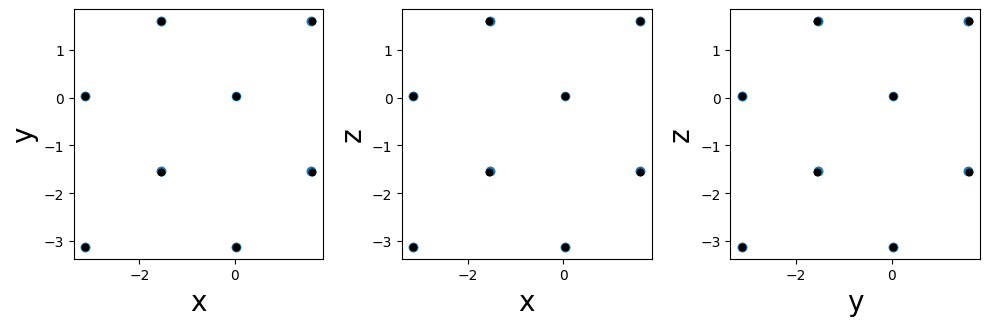

15


In [25]:
bcc_pure = Bcc(alat=3.163, ncell_x=2, minimize=True, logname=None,
                      data_path='./refs/', snapcoeff_filename='W.snapcoeff', verbose=False)
X_pure_3D = bcc_pure.X_coord.reshape(-1, 3)
X_target = np.array([0.0, 0.0, 0.0])
print(X_target.shape==(3,))
print((X_pure_3D-X_target).shape)
idx0 = np.argmin(np.linalg.norm(X_pure_3D-X_target, axis=1))
print(idx0)
print(bcc_pure.X_coord[idx0*3], bcc_pure.X_coord[idx0*3+1],bcc_pure.X_coord[idx0*3+2],)

bcc_vacancy = BccVacancy(alat=3.163, ncell_x=2, minimize=True, logname=None, del_coord=[0.0, 0.0, 0.0],
                      data_path='./refs/', snapcoeff_filename='W.snapcoeff', verbose=False)

fig, axes = plt.subplots(1, 3, figsize=(10, 5))
plot_tools.plot_coords(axes, bcc_vacancy.X_coord.reshape(-1, 3), s=35)
plot_tools.plot_coords(axes, bcc_pure.X_coord.reshape(-1, 3), color='black', s=20)
plt.tight_layout()
plt.show()

print(bcc_vacancy.Natom)

## Energy method

In [27]:
def sort_coord(X_coord):

    X_round = np.round(X_coord, decimals=8)
    X_3D = X_round.reshape(-1, 3)
    idx_sort = np.lexsort((X_3D[:, 2], X_3D[:, 1], X_3D[:, 0]))

    flat_indices = np.concatenate([np.arange(i*3, i*3+3) for i in idx_sort])

    return flat_indices

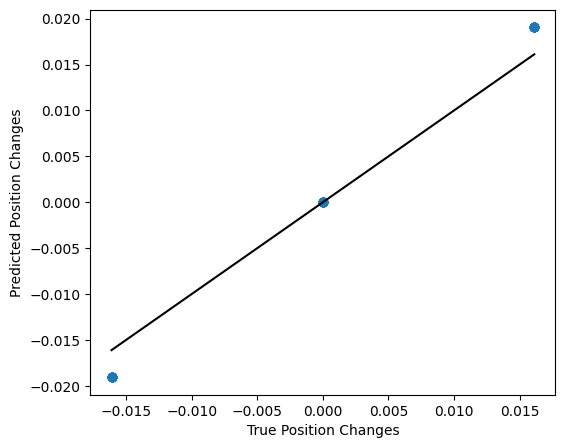

In [28]:
#min_style = 'sd'
min_style = 'cg'
dX_dTheta = bcc_vacancy.implicit_derivative(method='energy', adaptive_alpha=True, min_style=min_style, alpha=1e-6, ftol=1e-6, maxiter=100)

idx_sort = sort_coord(bcc_vacancy.X_coord)
dX_dTheta = dX_dTheta[:, idx_sort]

#dX_dTheta = dX_dTheta.reshape(bcc_vacancy.Ndesc, bcc_vacancy.Natom, 3)
#dX_dTheta = dX_dTheta[:, sort_coord(bcc_vacancy.X_coord), :]
#dX_dTheta = dX_dTheta.reshape(bcc_vacancy.Ndesc, bcc_vacancy.Natom*3)

np.save(f'test_impl_der_energy_{min_style}.npy', dX_dTheta)

X0 = bcc_vacancy.X_coord.copy()[idx_sort]

bcc_vacancy_perturb = BccVacancy(alat=3.163, ncell_x=2, minimize=True, logname=None, del_coord=[0.0, 0.0, 0.0],
                                 data_path='./refs', snapcoeff_filename='W_perturb.snapcoeff', snapparam_filename='W.snapparam', verbose=False)

dTheta = bcc_vacancy_perturb.Theta - bcc_vacancy.Theta

X_true = bcc_vacancy_perturb.X_coord.copy()[idx_sort]

dX_true = bcc_vacancy.minimum_image(X_true - X0)
dX_pred = dTheta @ dX_dTheta

dX_true -= dX_true.mean(axis=0)
dX_pred -= dX_pred.mean(axis=0)

np.save(f'test_impl_der_energy_dX_{min_style}.npy', dX_pred)

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.plot(dX_true, dX_pred, 'o')
ax.plot([dX_true.min(), dX_true.max()], [dX_true.min(), dX_true.max()], ls='-', color='black')
ax.set_xlabel('True Position Changes')
ax.set_ylabel('Predicted Position Changes')
plt.show()


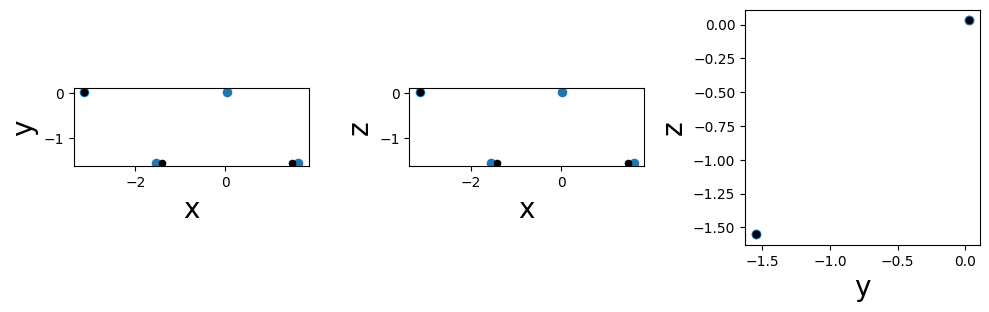

15


In [29]:
bcc_pure_211 = Bcc(alat=3.163, ncell_x=2, ncell_y=1, ncell_z=1, minimize=True, logname=None,
                      data_path='./refs/', snapcoeff_filename='W.snapcoeff', verbose=False)
bcc_vacancy_211 = BccVacancy(alat=3.163, ncell_x=2, ncell_y=1, ncell_z=1, minimize=True, logname=None,  del_coord=[0.0, 0.0, 0.0],
                      data_path='./refs/', snapcoeff_filename='W.snapcoeff', verbose=False)

fig, axes = plt.subplots(1, 3, figsize=(10, 5))
plot_tools.plot_coords(axes, bcc_pure_211.X_coord.reshape(-1, 3), s=35)
plot_tools.plot_coords(axes, bcc_vacancy_211.X_coord.reshape(-1, 3), color='black', s=20)
plt.tight_layout()
plt.show()

print(bcc_vacancy.Natom)

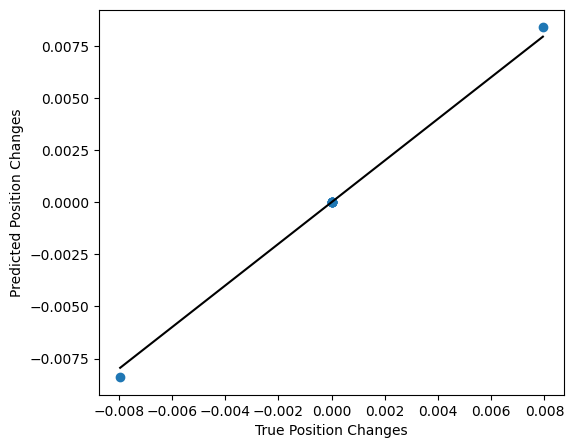

In [43]:
min_style = 'fire'
#min_style = 'cg'
dX_dTheta = bcc_vacancy_211.implicit_derivative(method='energy', adaptive_alpha=True, min_style=min_style, alpha=1e-3, ftol=1e-7, maxiter=50)
idx_sort = sort_coord(bcc_vacancy_211.X_coord)
X0 = bcc_vacancy_211.X_coord.copy()[idx_sort]
dX_dTheta = dX_dTheta[:, idx_sort]

np.save(f'test_impl_der_energy_{min_style}.npy', dX_dTheta)

bcc_vacancy_211_perturb = BccVacancy(alat=3.163, ncell_x=2, ncell_y=1, ncell_z=1, minimize=True, logname=None, del_coord=[0.0, 0.0, 0.0],
                                 data_path='./refs', snapcoeff_filename='W_perturb2.snapcoeff', snapparam_filename='W.snapparam', verbose=False)

X_true = bcc_vacancy_211_perturb.X_coord.copy()[idx_sort]

dX_true = bcc_vacancy_211.minimum_image(X_true - X0)

dTheta = bcc_vacancy_211_perturb.Theta - bcc_vacancy_211.Theta
dX_pred = dTheta @ dX_dTheta

dX_true -= dX_true.mean(axis=0)
dX_pred -= dX_pred.mean(axis=0)

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.plot(dX_true, dX_pred, 'o')
ax.plot([dX_true.min(), dX_true.max()], [dX_true.min(), dX_true.max()], ls='-', color='black')
ax.set_xlabel('True Position Changes')
ax.set_ylabel('Predicted Position Changes')
plt.show()